## <center> **Comparing Unsupervised Machine Learning Algorithms with Leukemia Data**
### <center> **by Trent Rivers** <br>CSPB 4622 - Machine Learning <br> Github: <br> https://github.com/cu-cspb-4622-summer-2025/P2-trentbrivers#

#### **Introduction**
The objective of this project is to explore applications of unsupervised machine learning, where a model uses no human-derived labels during the training process. Expectedly, the applications of unsupervised learning differ from those of supervised learning. Regression and Classification are not possible with unsupervised learning algorithms; instead, unsupervised learning models excel at tasks that, firstly, help us understand the overall dataset, through methods like finding subgroups, clustering, and helping create visualizations, and, secondly, through processing and creating data for use with other models through dimensionality reduction, preprocessing, and data synthesis. 
    
This project will explore two applications of unsupervised machine learning. The first will be clustering. While unsupervised learning models can not accomplish classification in the typical sense, clustering, in effect, captures much of the same meaning as multi-class classification. To this end, K-Means and Hierarchical Clustering will be used. Unsupervised learning can also be used for dimensionality reduction. This can be a helpful first step when attempting to use supervised learning models that suffer when a particular high-dimemsion dataset is in use. For this task, Principal Component Analysis will be used to process data before training a Decision Tree Classifier and a Random Forest Classifier (two models that both support multiclass classification and also suffer when dimensionality is high). 
    
The metrics used to evaluate these models will be Accuracy, Precision, Recall, and F1 score.

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tqdm import tqdm
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

#### **The Dataset**

The dataset in use for this project will be one of the Leukemia dataset (GSE 28497) from the Structural Bioinformatics and Computational Biology Lab's Curated Microarray Database (CuMiDa) at https://sbcb.inf.ufrgs.br/cumida#datasets

This is a set of curated and handpicked cancer datasets for data science applications.

This dataset consists of 281 samples with features consisting of 22284 genes. These samples are split across 7 classes. 
Each class represents a type of leukemia:
* B-CELL-ALL: B-cell acute lymphoblastic leukemia
* B-CELL-ALL-ETV6-RUNX1: B-cell acute lymphoblastic leukemia with ETV6/RUNX1 fusion
* B-CELL-ALL-HYPERDIP: B-cell acute lymphoblastic leukemia with hyperdiploidy
* B-CELL-ALL-HYPO: B-cell acute lymphoblastic leukemia with hypodiploidy
* BE-CELL-ALL-MLL: B-cell acute lymphoblastic leukemia with MLL rearrangement
* B-CELL-ALL-T-ALL: T-cell acute Lymphoblastic leukemia
* B-CELL-ALL-TCF3-PBX1: B-cell acute lymphoblastic leukemia with TCF3-PBX1 fusion

Different multiclass classification models have also been benchmarked against each other using this dataset, so this gives us a beginning point to compare against. 

![data.png](img/data.png)

In [21]:
data = pd.read_csv("data/Leukemia_GSE28497.csv")

### **Exploratory Data Analysis and Data Preparation**

In [22]:
data.head(5)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM705467.CEL.gz,B-CELL_ALL,7.409521,5.009216,4.173607,7.315369,3.185411,7.620644,3.731541,3.471587,...,2.968822,3.223820,11.968681,12.100004,3.457507,2.967138,2.790814,2.563377,2.860505,2.608381
1,GSM705468.CEL.gz,B-CELL_ALL,7.177109,5.415108,4.426778,7.550818,3.134181,7.685723,3.907953,3.650995,...,2.982888,3.690411,12.318004,12.486741,3.396412,3.109629,2.856499,2.603355,2.908509,2.634063
2,GSM705469.CEL.gz,B-CELL_ALL,6.564918,5.248020,4.252414,7.175169,3.017718,7.956261,3.354557,3.302989,...,2.897425,3.611584,11.748222,11.807578,3.265585,3.057079,2.724642,2.440532,2.626871,2.673293
3,GSM705470.CEL.gz,B-CELL_ALL,6.872028,5.155963,4.388849,7.365933,3.031735,7.830002,3.508926,3.412491,...,3.024722,3.713087,12.208588,12.148604,3.175092,2.896168,2.798296,2.522343,2.762835,2.624163
4,GSM705471.CEL.gz,B-CELL_ALL,7.402105,5.509826,4.284291,7.214947,2.925269,7.789838,3.610425,3.362593,...,3.259802,4.096010,11.641305,11.713311,3.507025,3.119397,2.761294,2.546541,2.748511,2.738165


From the above, we can tell that two things need to occur: the first column ought to be removed since it only indicates the file the sample came from, and then separate off the second column as the labels for the rest of the dataset.

In [23]:
labels = data['type']
data.drop(labels=['samples', 'type'], axis = 1, inplace = True)

For a dataset of this size, printing summary statistics for every feature is not feasible. Instead, let us calculate all of the summary statistics at once and plot the distribution of the results.

In [24]:
data_array = data.to_numpy()
data_means = data_array.mean(axis = 0)
data_maxs = data_array.max(axis = 0)
data_mins = data_array.min(axis = 0)
data_75_q = np.quantile(data_array, 0.75, axis = 0)
data_50_q = np.quantile(data_array, 0.5, axis = 0)
data_25_q = np.quantile(data_array, 0.25, axis = 0)


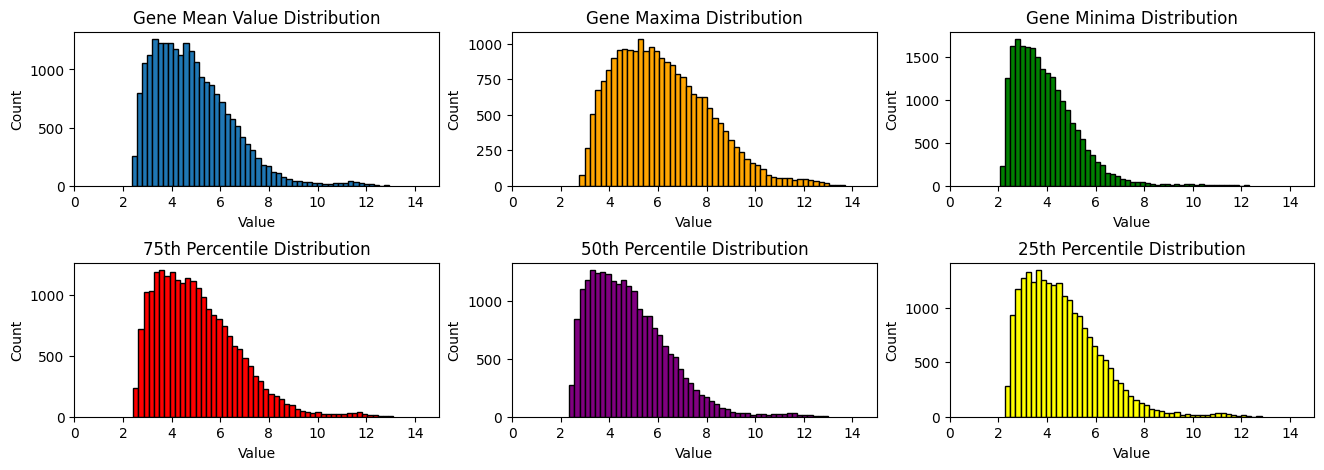

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 5))
ax[0][0].hist(data_means, edgecolor = 'black', bins = 50)
ax[0][0].set_title("Gene Mean Value Distribution")
ax[0][0].set_xlabel("Value")
ax[0][0].set_ylabel("Count")
ax[0][0].set_xlim(0,15)
ax[0][1].hist(data_maxs, edgecolor = 'black', bins = 50, color = 'orange')
ax[0][1].set_title("Gene Maxima Distribution")
ax[0][1].set_xlabel("Value")
ax[0][1].set_ylabel("Count")
ax[0][1].set_xlim(0,15)
ax[0][2].hist(data_mins, edgecolor = 'black', bins = 50, color = 'green')
ax[0][2].set_title("Gene Minima Distribution")
ax[0][2].set_xlabel("Value")
ax[0][2].set_ylabel("Count")
ax[0][2].set_xlim(0,15)
ax[1][0].hist(data_75_q, edgecolor = 'black', bins = 50, color = 'red')
ax[1][0].set_title("75th Percentile Distribution")
ax[1][0].set_xlabel("Value")
ax[1][0].set_ylabel("Count")
ax[1][0].set_xlim(0,15)
ax[1][1].hist(data_50_q, edgecolor = 'black', bins = 50, color = 'purple')
ax[1][1].set_title("50th Percentile Distribution")
ax[1][1].set_xlabel("Value")
ax[1][1].set_ylabel("Count")
ax[1][1].set_xlim(0,15)
ax[1][2].hist(data_25_q, edgecolor = 'black', bins = 50, color = 'yellow')
ax[1][2].set_title("25th Percentile Distribution")
ax[1][2].set_xlabel("Value")
ax[1][2].set_ylabel("Count")
ax[1][2].set_xlim(0,15)
plt.subplots_adjust(hspace=0.5) 
plt.show()

Looking at the distributions above, it's difficult to contextualize all of the summary statistics next to each other. The overlapping plot below has been created to help with that. 

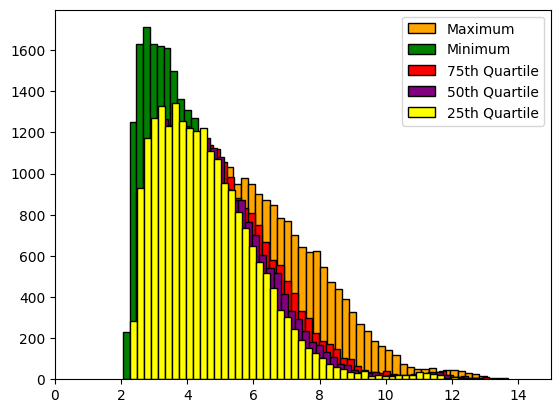

In [26]:
plt.hist(data_maxs, edgecolor = 'black', bins = 50, color = 'orange', label = 'Maximum')
plt.hist(data_mins, edgecolor = 'black', bins = 50, color = 'green', label = 'Minimum')
plt.hist(data_75_q, edgecolor = 'black', bins = 50, color = 'red', label = '75th Quartile')
plt.hist(data_50_q, edgecolor = 'black', bins = 50, color = 'purple', label = '50th Quartile')
plt.hist(data_25_q, edgecolor = 'black', bins = 50, color = 'yellow', label = '25th Quartile')
plt.xlim(0,15)
plt.legend()
plt.show()

Encouragingly, there appear to be no missing values or inexplicable extremes that need to be cleaned from the dataset. All values fall within the same range. Though the quartiles all overlap, it is likely the minima and maxima that will define the distinctions between the classes after training. 

With a dataset of this size, it's unrealistic to create a correlation matrix - comparing 20000 features against each other would result in 20000^2 plots, which is more than any one person could analyze. 

Since it is already known that all of the data represents genes and all values cover the same range, additional cleaning is unnecessary.

One potential problem with the dataset is the number of samples present. With 7 classes represented among 281 samples, it may not be possible to form accurate clusters or train a model to accurately label all 7 classes.

Let's look at the representation of each class in the dataset.

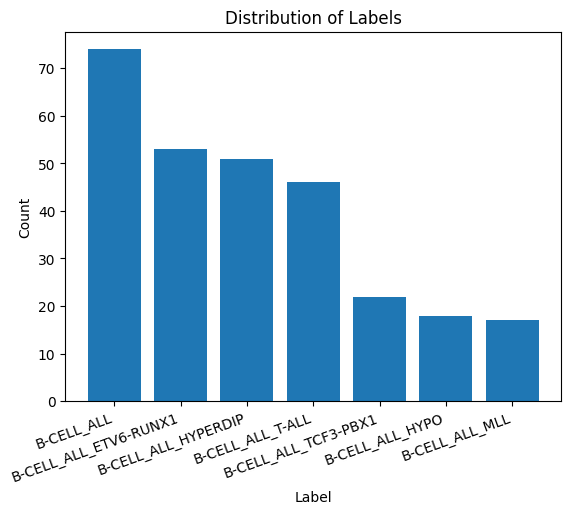

In [27]:
plotting_labels = labels.value_counts()
plt.bar(plotting_labels.index, plotting_labels.values)
plt.xticks(plotting_labels.index, rotation = 20, ha = 'right')
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

As I suspected, the labels are represented unevenly in the data, so this coupled with the size of the dataset could limit the potential accuracy of any model. 

#### **Normalizing the Data**

Given the models in use, like PCA and K-Means, standardizing the features would probably be helpful. Both PCA and K-Means are susceptible to biasing due to the scale of the features.

In [41]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

## Building Models

Now that EDA has been completed, it is now time to begin working with our unsupervised models. The models that will be used are Hierarchical Clustering, K-Means Clustering, and Principal Component Analysis with Decision Tree and Random Forest Classifiers. Clustering is similar to multiclass classification without labels using labels, so clustering models can be directly compared against supervised learning models (as seen in the comparison presented with the dataset). The basis for using the aforementioned models is this: 
* K-Means: among clustering algorithms, K-Means is likely one of the oldest and most well-known. However, by no means does its age mean that it is out-dated to use. The elegance of K-Means is in its simplicity - it functions off of three simple steps (assign a cluster centroid, calculate distances, and reassign cluster values). K-Means remains useful because of its simplicity and, as an unsupervised learning method, can function with even extraordinarily high-dimension data.
* Hierarchical Clustering: this is another clustering method, yet unlike K-Means, the number of clusters does not need to be defined in advance. Additionally, while the choice of the initial centroids of K-Means can have an impact on the converged clusterings, Hierarchical Clustering is deterministic, meaning results should be consistent upon convergence. Hierarchical Clustering represents a distinct approach to clustering compared to K-Means, and it will be useful to compare the two.
* Principal Component Analysis: Unsupervised learning has other applications than clustering, and preprocessing data is one of them. While it would be excellent to live in a world where all datasets were perfectly usable for all tasks and models all of the time, that is not realistic. For many models and tasks, like those used in supervised learning, the dimensionality of a dataset can prohibit models from performing well. Principal Component Analysis can reduce a high-dimension feature set to only the most useful subset of features, which can then be used with supervised learning methods. 

The processed data from PCA will be used with both a Decision Tree and a Random Forest Classifier because (1) both models suffer when data is too high-dimensional, and (2) both models natively support multiclass classification, providing us with a point of comparison with the clustering algorithms mentioned above.


### Baselining - Weighted Random Choice

The simplest method to compare against would be to take the distribution of labels within the original, and make a weighted choice based on those probabilities. 

In [29]:
probabilities = plotting_labels.values/data.shape[0]

In [52]:
choice_prob = np.random.choice(plotting_labels.index, size = data_t.shape[0], p = probabilities)
choice_accuracy = accuracy_score(labels, choice_prob)
choice_precision = precision_score(labels, choice_prob, average = 'weighted')
choice_recall = recall_score(labels, choice_prob, average = 'weighted')
choice_f1 = f1_score(labels, choice_prob, average = 'weighted')
print("Weighted Choice Accuracy: ", choice_accuracy)
print("Weighted Choice Precision: ", choice_precision)
print("Weighted Choice Recall: ", choice_recall)
print("Weighted Choice F1: ", choice_f1)

Weighted Choice Accuracy:  0.19217081850533807
Weighted Choice Precision:  0.18888879077146786
Weighted Choice Recall:  0.19217081850533807
Weighted Choice F1:  0.18961195792083882


As expected, this value isn't particularly high; however, this gives us a simple value to compare against. It's not quite random because the distribution of labels is taken into account. From here, it is possible to see h

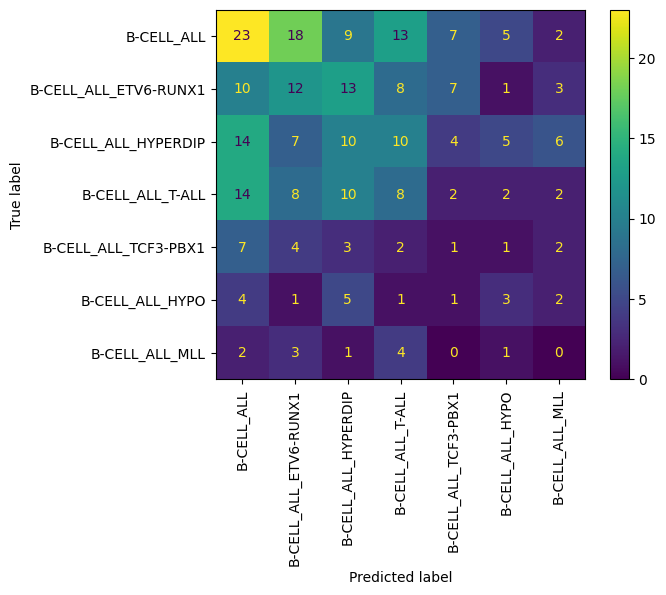

In [15]:
cm = confusion_matrix(choice_prob, labels)
disp = ConfusionMatrixDisplay(cm)
disp.from_predictions(choice_prob, labels, labels = plotting_labels.index,xticks_rotation = 'vertical')
# disp.plot()
# plt.show()

### K-Means

K-Means is a simple algorithm, but its repercussions are quite astounding. For example, using the MNIST dataset, K-Means is able to extract written human numerals from simple vectors of white values. In this case, the goal is to form clusters that represent the seven different classifications in the dataset. 

In [47]:
import itertools

def label_permute_compare(yt,yp,n=5):
    """
    yt: labels series object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    """
    
    perms = list(itertools.permutations(range(n)))
    best_combo = tuple([np.zeros(n), 0.00])
    yt_labels = labels.value_counts()
    
    converted_original = yt.copy(deep = True).replace(yt_labels.index, list(range(n))).astype(int)

    for current in tqdm(range(len(perms))):
        p = perms[current]
        fresh_copy = pd.Series(yp.copy())
        fresh_copy.replace(list(range(n)), list(p), inplace = True)
        current_acc = accuracy_score(converted_original, fresh_copy)
        best_combo = max([best_combo, (p, current_acc)], key = lambda e: e[1])
        
    best_res = pd.Series(yp.copy()).replace(list(range(n)), best_combo[0])
    best_res.replace(list(range(n)), yt_labels.index, inplace = True)
        
    return best_res

In [70]:
km = KMeans(n_clusters = 7, max_iter = 50)
km.fit(data_scaled)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=7)

In [71]:
km_pred = label_permute_compare(labels, km.labels_, 7)

100%|██████████| 5040/5040 [00:09<00:00, 506.12it/s]


In [72]:
km_accuracy = accuracy_score(labels, km_pred)
km_precision = precision_score(labels, km_pred, average = 'weighted')
km_recall = recall_score(labels, km_pred, average = 'weighted')
km_f1 = f1_score(labels, km_pred, average = 'weighted')
print("K-Means Accuracy: ", km_accuracy)
print("K-Means Precision: ", km_precision)
print("K-Means Recall: ", km_recall)
print("K-Means F1: ", km_f1)

K-Means Accuracy:  0.5231316725978647
K-Means Precision:  0.6425099774651631
K-Means Recall:  0.5231316725978647
K-Means F1:  0.5644057164407561


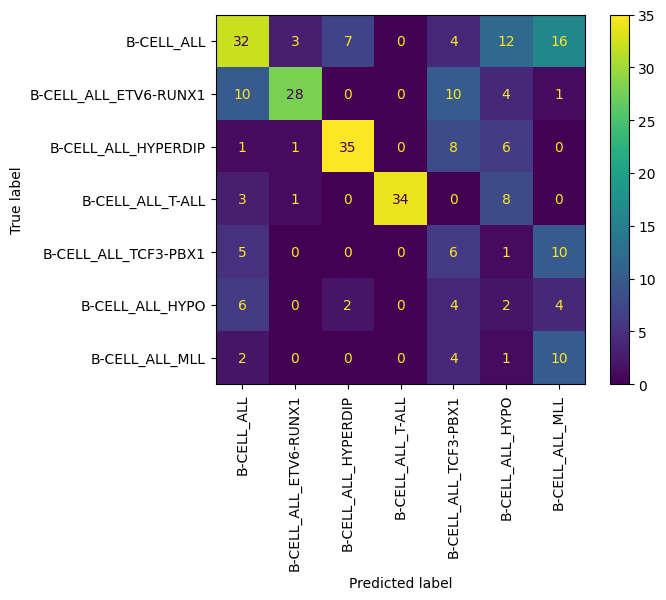

In [81]:
cm_km = confusion_matrix(labels, km_pred)
disp = ConfusionMatrixDisplay(cm_km)
disp.from_predictions(labels, km_pred, labels = plotting_labels.index,xticks_rotation = 'vertical')

#### Will there be hyperparameter tuning?

As an algorithm, the only real hyperparameter for K-Means is the value of K, the number of clusters. Since the number of clusters is known ahead of time, this effectively nullifies the need for additional tuning. There are a number of parameters on Sklearn's KMeans class that can influence how long it takes to converge and when it stops, including max_iter, tol (tolerance), and n_init (number of repetitions to run K-Means and pick the best). Given enough time, K-Means will always converge, so the trade-off is to change the KMeans class to use more iterations, a lower tolerance, and more repetitions in exchange for more time to converge. Since the results observed in testing here have exceeded those of this dataset's host using K-Means, there appears little need to continue when time is the only factor.

However, for the sake of doing something, here is a version with 5 times the number of iterations above.

In [82]:
km_tuned = KMeans(n_clusters = 7, max_iter = 250)
km_tuned.fit(data_scaled)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=250, n_clusters=7)

In [83]:
km_tuned_pred = label_permute_compare(labels, km_tuned.labels_, 7)

100%|██████████| 5040/5040 [00:09<00:00, 527.65it/s]


In [84]:
km_tuned_accuracy = accuracy_score(labels, km_tuned_pred)
km_tuned_precision = precision_score(labels, km_tuned_pred, average = 'weighted')
km_tuned_recall = recall_score(labels, km_tuned_pred, average = 'weighted')
km_tuned_f1 = f1_score(labels, km_tuned_pred, average = 'weighted')
print("K-Means Accuracy: ", km_tuned_accuracy)
print("K-Means Precision: ", km_tuned_precision)
print("K-Means Recall: ", km_tuned_recall)
print("K-Means F1: ", km_tuned_f1)

K-Means Accuracy:  0.4555160142348754
K-Means Precision:  0.49529383689774337
K-Means Recall:  0.4555160142348754
K-Means F1:  0.4486681999264973


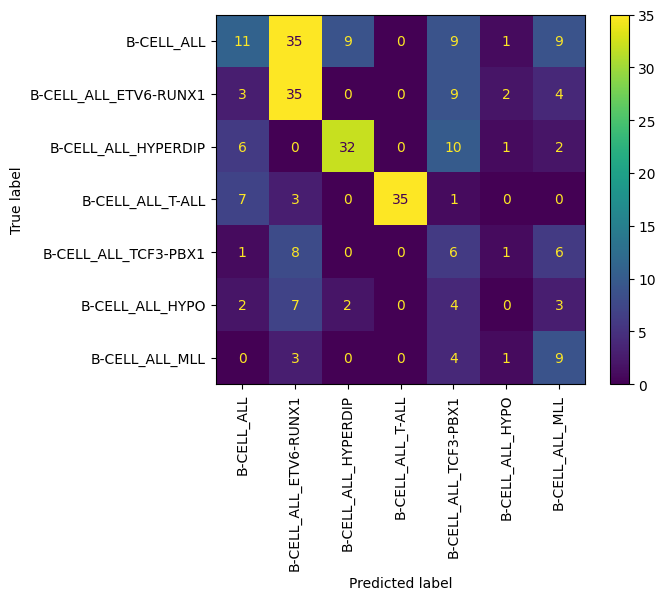

In [85]:
cm_km_tuned = confusion_matrix(labels, km_tuned_pred)
disp = ConfusionMatrixDisplay(cm_km_tuned)
disp.from_predictions(labels, km_tuned_pred, labels = plotting_labels.index,xticks_rotation = 'vertical')

It appears more time to converge is bringing the values of K-Means ever closer to the established performance of the dataset's host (0.45). Perhaps the dataset is too small to clearly distinguish the classes 

### Hierarchical Clustering

Hierarchical Clustering represents an alternative approach to clustering than K-Means. It recursively merges smaller clusters of sample data using a "linkage distance", and then uses a threshold to parse the exact number of clusters to describe. One of the main benefits of Hierarchical Clustering is the consistent nature of the results it will produce. This is unlike K-Means where the choice of initial centroids can impact how the clusters develop and eventually converge. 

In [86]:
hc = AgglomerativeClustering(n_clusters = 7)
hc.fit(data_scaled)

AgglomerativeClustering(n_clusters=7)

In [87]:
hc_pred = label_permute_compare(labels, hc.labels_, 7)

100%|██████████| 5040/5040 [00:09<00:00, 535.58it/s]


In [89]:
hc_accuracy = accuracy_score(labels, hc_pred)
hc_precision = precision_score(labels, hc_pred, average = 'weighted')
hc_recall = recall_score(labels, hc_pred, average = 'weighted')
hc_f1 = f1_score(labels, hc_pred, average = 'weighted')
print("K-Means Accuracy: ", hc_accuracy)
print("K-Means Precision: ", hc_precision)
print("K-Means Recall: ", hc_recall)
print("K-Means F1: ", hc_f1)

K-Means Accuracy:  0.4875444839857651
K-Means Precision:  0.5366021064890909
K-Means Recall:  0.4875444839857651
K-Means F1:  0.49444343618888803


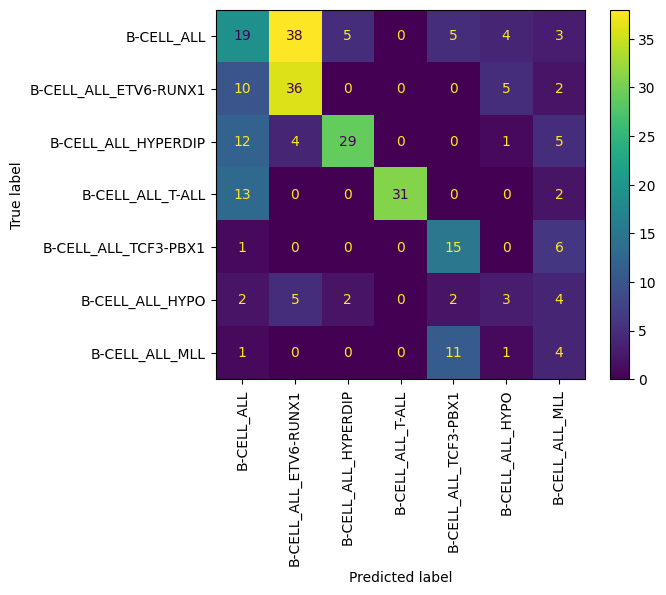

In [88]:
cm_hc = confusion_matrix(labels, hc_pred)
disp = ConfusionMatrixDisplay(cm_hc)
disp.from_predictions(labels, hc_pred, labels = plotting_labels.index,xticks_rotation = 'vertical')

The performance seen above exceeds that of the K-Means predictor even before any tuning has occurred, which is a positive sign. 

#### Hyperparameter tuning

For the Sklearn implementation of Hierarchical Clustering, AgglomerativeClustering, there are a couple of different parameters to change. These include the metric used to compute the linkage when making clusters and the linkage criterion to use. The below code will do the equivalent of Sklearn's GridSearchCV but will avoid the exception that the 'ward' linkage type can only be used with the euclidean metric. 

In [92]:
links = ['ward','complete','average','single']
metr = ['euclidean','manhattan','cosine', 'l1','l2']
best = tuple(['','',0.00])
for l in links:
    for m in metr:
        if (l == 'ward' and m != 'euclidean'):
            continue
        bestimator = AgglomerativeClustering(n_clusters = 7, metric = m, linkage = l)
        bestimator.fit(data_scaled)
        out = label_permute_compare(labels, bestimator.labels_, 7)
        a = accuracy_score(labels, out)
        print(l, m, a)
        best = max([best, (l,m, a)], key = lambda e: e[2])
        
print("final best combo and accuracy:", best)

100%|██████████| 5040/5040 [00:10<00:00, 458.41it/s]


ward euclidean 0.4875444839857651


100%|██████████| 5040/5040 [00:11<00:00, 454.91it/s]


complete euclidean 0.302491103202847


100%|██████████| 5040/5040 [00:11<00:00, 446.29it/s]


complete manhattan 0.3487544483985765


100%|██████████| 5040/5040 [00:08<00:00, 597.41it/s]


complete cosine 0.3665480427046263


100%|██████████| 5040/5040 [00:07<00:00, 651.26it/s]


complete l1 0.3487544483985765


100%|██████████| 5040/5040 [00:08<00:00, 582.34it/s]


complete l2 0.302491103202847


100%|██████████| 5040/5040 [00:09<00:00, 538.03it/s]


average euclidean 0.2669039145907473


100%|██████████| 5040/5040 [00:10<00:00, 500.47it/s]


average manhattan 0.26334519572953735


100%|██████████| 5040/5040 [00:10<00:00, 490.54it/s]


average cosine 0.4483985765124555


100%|██████████| 5040/5040 [00:10<00:00, 496.59it/s]


average l1 0.26334519572953735


100%|██████████| 5040/5040 [00:09<00:00, 509.42it/s]


average l2 0.2669039145907473


100%|██████████| 5040/5040 [00:09<00:00, 506.41it/s]


single euclidean 0.2669039145907473


100%|██████████| 5040/5040 [00:11<00:00, 435.99it/s]


single manhattan 0.2669039145907473


100%|██████████| 5040/5040 [00:09<00:00, 524.97it/s]


single cosine 0.24199288256227758


100%|██████████| 5040/5040 [00:10<00:00, 481.11it/s]


single l1 0.2669039145907473


100%|██████████| 5040/5040 [00:10<00:00, 485.06it/s]

single l2 0.2669039145907473
final best combo and accuracy: ('ward', 'euclidean', 0.4875444839857651)


The final best combination of hyperparameters matched the defaults used to create the original Clustering model. Therefore, there is little reason to repeat the same code here when the clustering performance has been established above.  

### Principal Component Analysis

Princial Component Analysis is helpful for reducing a high-dimensional feature set to only the most useful features. It uses the eigenvalues and eigenvectors after successive Singular Value Decompositions to create a total explained variance from the new eigenvector features. For this particular dataset, with 22,284 genes all with values in a similar range, attempting to discern the most useful features by intuition or through visualization is near impossible. Reducing the dataset through Principal Component Analysis is a near absolute necessity to use other methods that suffer when data is too high-dimensional, like Decision Trees or Random Forests.

With this dataset, the goal is to reduce the number of features to the set of principal components that explain 95% of the variance in the dataset.

In [95]:
pca = PCA(n_components = 0.95) #Explain 95% of variance
data_pca = pca.fit_transform(data_scaled)

In [100]:
print("Total features after PCA: ", data_pca.shape[1])
print("Feature Reduction ratio: ", str((1-data_pca.shape[1]/data_scaled.shape[1])*100) + "%")

Total features after PCA:  217
Feature Reduction ratio:  99.02616344298345%


A 99% reduction in the number of features should make it possible to use other models with this data going forward.

In [101]:
X_train, X_test, y_train, y_test = train_test_split(data_pca, labels, test_size = 0.2)

#### PCA & Decision Tree

Decision Trees are a popular supervised learning model for a number of reasons. They are quick to train, easy to understand, and require minimal data preparation. However, when working with high-dimensional datasets, a Decision Tree can start to suffer because of overfitting with many irrelevant features. Principal Component Analysis offers an excellent way to address this by distilling the original dataset into a more compact set. 

##### Baseline Tree

In [102]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [114]:
dt_pred = dt.predict(X_test)

In [115]:
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred, average = 'weighted')
dt_recall = recall_score(y_test, dt_pred, average = 'weighted')
dt_f1 = f1_score(y_test, dt_pred, average = 'weighted')
print("Decision Tree Accuracy: ", dt_accuracy)
print("Decision Tree Precision: ", dt_precision)
print("Decision Tree Recall: ", dt_recall)
print("Decision Tree F1: ", dt_f1)

Decision Tree Accuracy:  0.543859649122807
Decision Tree Precision:  0.5874231032125768
Decision Tree Recall:  0.543859649122807
Decision Tree F1:  0.5596169552119209


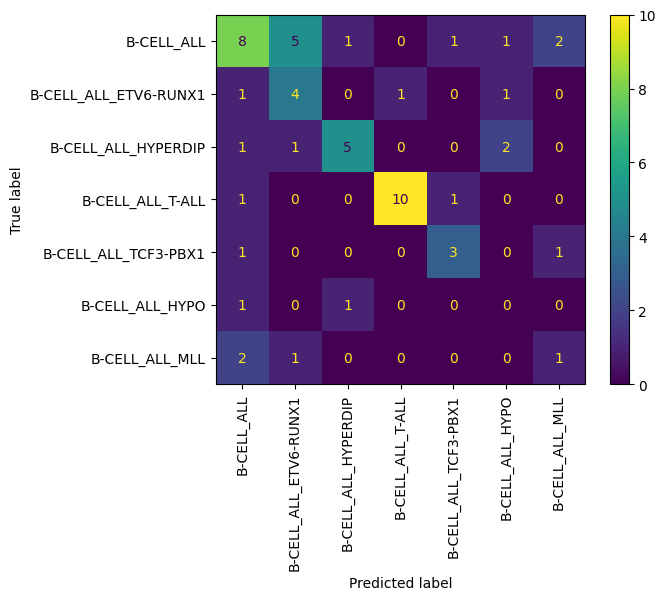

In [117]:
cm_dt = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(cm_dt)
disp.from_predictions(y_test, dt_pred, labels = plotting_labels.index,xticks_rotation = 'vertical')

##### Hyperparameter Tuning

Decision Trees have a number of hyperparameters that may be tuned for better performance. These include:
* max_depth: the maximum depth of the tree
* min_samples_split: the minimum number of samples required to split an internal node
* min_samples_leaf: the minimum number of samples required to be at a leaf node
* ccp_alpha: enable Minimal Cost-Complexity Pruning, removing the subtree with the largest cost complexity that is smaller than ccp_alpha

Tuning will be performed using Sklearn's GridSearchCV.

In [129]:
#Kept for posterity
# md = np.arange(20)
# mss = np.arange(2, 20)
# msl = np.arange(20)
# ccp = np.arange(0.0, 0.5, 0.05)
# p_grid = {'max_depth':md, 'min_samples_split':mss, 'min_samples_leaf': msl, 'ccp_alpha':ccp}

# grid = GridSearchCV(DecisionTreeClassifier(), p_grid, scoring = 'accuracy')
# grid.fit(X_train, y_train)

#Version 2
md = np.arange(5,20,1)
msl = np.arange(5,20,1)
p_grid = {'max_depth':md, 'min_samples_leaf': msl}

grid = GridSearchCV(DecisionTreeClassifier(), p_grid, scoring = 'accuracy')
grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             scoring='accuracy')

In the above code, attempting to train trees with so many parameters tuned simultaneously took in excess of half an hour with no indication that training would cease soon. For that reason, the number of tuning parameters has been reduced to only max_depth and min_samples_leaf. Previous testing has shown these are the hyperparameters that most impact performance.

In [130]:
best_dt = grid.best_estimator_
best_dt_pred = best_dt.predict(X_test)

In [131]:
best_dt_accuracy = accuracy_score(y_test, best_dt_pred)
best_dt_precision = precision_score(y_test, best_dt_pred, average = 'weighted')
best_dt_recall = recall_score(y_test, best_dt_pred, average = 'weighted')
best_dt_f1 = f1_score(y_test, best_dt_pred, average = 'weighted')
print("Tuned Decision Tree Accuracy: ", best_dt_accuracy)
print("Tuned Decision Tree Precision: ", best_dt_precision)
print("Tuned Decision Tree Recall: ", best_dt_recall)
print("Tuned Decision Tree F1: ", best_dt_f1)

Tuned Decision Tree Accuracy:  0.49122807017543857
Tuned Decision Tree Precision:  0.5824413976116762
Tuned Decision Tree Recall:  0.49122807017543857
Tuned Decision Tree F1:  0.5193435142881127


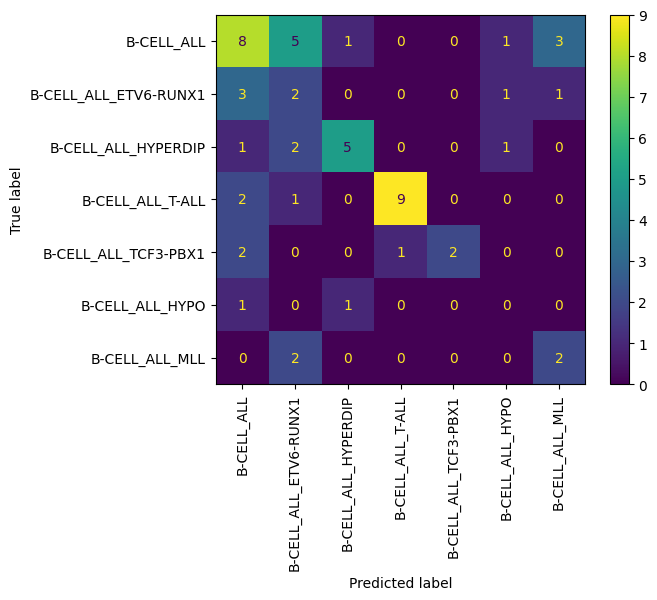

In [132]:
cm_bdt = confusion_matrix(y_test, best_dt_pred)
disp = ConfusionMatrixDisplay(cm_bdt)
disp.from_predictions(y_test, best_dt_pred, labels = plotting_labels.index,xticks_rotation = 'vertical')

Disappointingly, what was meant to be a tuned tree has failed to match the performance of the baseline Decision Tree. 

#### PCA & Random Forest

A Random Forest is built on smaller decision trees that have been fitted on various sub-samples of the dataset and uses averaging to improve accuracy and control against over-fitting. Since Random Forests derive from Decision Trees, they too suffer when the dimensionality of data is high; however, with a dataset that has been processed with Principal Component Analysis, it is possible for the Random Forest to perform better. 

##### Baseline Random Forest

In [133]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [134]:
rf_pred = rf.predict(X_test)

In [136]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average = 'weighted')
rf_recall = recall_score(y_test, rf_pred, average = 'weighted')
rf_f1 = f1_score(y_test, rf_pred, average = 'weighted')
print("Random Forest Accuracy: ", rf_accuracy)
print("Random Forest Precision: ", rf_precision)
print("Random Forest Recall: ", rf_recall)
print("Random Forest F1: ", rf_f1)

Random Forest Accuracy:  0.6491228070175439
Random Forest Precision:  0.6350185809350963
Random Forest Recall:  0.6491228070175439
Random Forest F1:  0.6139287799422177


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


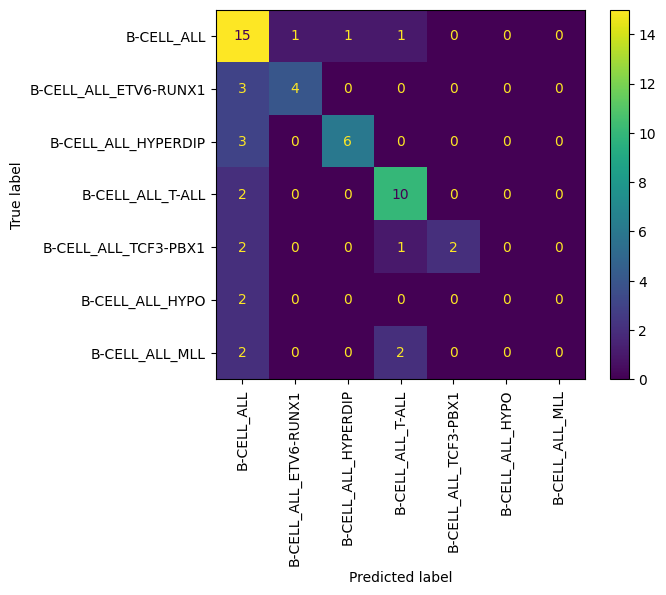

In [137]:
cm_rf = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(cm_rf)
disp.from_predictions(y_test, rf_pred, labels = plotting_labels.index,xticks_rotation = 'vertical')

##### Hyperparameter Tuning
Since Random Forests are built on top of smaller Decision Trees, they have all of the same hyperparameters with a handful of hyperparameters that are specific to them. The unique hyperparameters include: 
* n_estimators: the number of smaller decision trees that are trained to make up the Random Forest
* bootstrap & max_samples: bootstrap is binary that controls whether max_samples # of samples are used to train each individual tree. 

In [140]:
p = grid.best_params_

In [141]:
est = np.arange(50,100, 5)
bootstrap = [False, True]
max_samples = np.arange(0.2, 1.0, 0.1)
params = {'n_estimators': est, 'bootstrap': bootstrap, 'max_samples':max_samples}

grid_rf = GridSearchCV(RandomForestClassifier(max_depth = p['max_depth'], min_samples_leaf = p['min_samples_leaf']), params, scoring = 'accuracy')
grid_rf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 397, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/opt/conda/lib

GridSearchCV(estimator=RandomForestClassifier(max_depth=6, min_samples_leaf=7),
             param_grid={'bootstrap': [False, True],
                         'max_samples': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'n_estimators': array([50, 55, 60, 65, 70, 75, 80, 85, 90, 95])},
             scoring='accuracy')

In [144]:
best_rf = grid_rf.best_estimator_

In [145]:
best_rf_pred = best_rf.predict(X_test)

In [146]:
best_rf_accuracy = accuracy_score(y_test, best_rf_pred)
best_rf_precision = precision_score(y_test, best_rf_pred, average = 'weighted')
best_rf_recall = recall_score(y_test, best_rf_pred, average = 'weighted')
best_rf_f1 = f1_score(y_test, best_rf_pred, average = 'weighted')
print("Random Forest Accuracy: ", best_rf_accuracy)
print("Random Forest Precision: ", best_rf_precision)
print("Random Forest Recall: ", best_rf_recall)
print("Random Forest F1: ", best_rf_f1)

Random Forest Accuracy:  0.631578947368421
Random Forest Precision:  0.6174463937621832
Random Forest Recall:  0.631578947368421
Random Forest F1:  0.5915720674234606


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Results & Analysis

The metrics selected to evaluate all of these models are accuracy, precision, recall, and f1. The reasoning for selecting these metrics is as follows:
* Accuracy: it computes the fraction of correct predictions over all predictions; it is helpful to understand the overall correctness of a model
* Precision: in essence, precision tells us how accurate predictions were per class. It answers the question "What was the percentage of class prediction that were correct?" Here, in a multi-class application, an average of precisions across all classes is used. It measures something different from pure accuracy. 
* Recall: recall is the ability of the classifier to find all the positive samples of a class [1]. It tells us how many instances of a class were correctly predicted out of all instanes of a class. Once again, this is distinct from Precision and Recall. 
* F1: it incorporates both Precision and Recall into a single metric through a weighted harmonic mean of both - since it is a combination of metrics, it can be more a more useful point of comparison 

First, it would be useful to collect all of the results here to compare performance directly. The results table is sorted by accuracy.

In [172]:
model_type = ['Weighted Choice', 'K-Means', 'Tuned K-Means', 'Hierarchical Clustering', 'Tuned Hieararhical Clustering', 'PCA & Decision Tree', 'Tuned PCA & Decision Tree', 'PCA & Random Forest', 'Tuned PCA & Random Forest']
acc = [choice_accuracy, km_accuracy,km_tuned_accuracy,hc_accuracy,hc_accuracy,dt_accuracy,best_dt_accuracy,rf_accuracy,best_rf_accuracy]
prec = [choice_precision, km_precision,km_tuned_precision,hc_precision,hc_precision,dt_precision,best_dt_precision,rf_precision,best_rf_precision]
rec = [choice_recall, km_recall,km_tuned_recall,hc_recall,hc_recall,dt_recall,best_dt_recall,rf_recall,best_rf_recall]
f1 = [choice_f1, km_f1,km_tuned_f1,hc_f1,hc_f1,dt_f1,best_dt_f1,rf_f1,best_rf_f1]

results_df = pd.DataFrame(data = {'Model Type': model_type, 'Accuracy':acc, 'Precision':prec, 'Recall': rec,'F1':f1})
results_df.sort_values(by='Accuracy', ascending = False)

,Model Type,Accuracy,Precision,Recall,F1
7,PCA & Random Forest,0.649123,0.635019,0.649123,0.613929
8,Tuned PCA & Random Forest,0.631579,0.617446,0.631579,0.591572
5,PCA & Decision Tree,0.543860,0.587423,0.543860,0.559617
1,K-Means,0.523132,0.642510,0.523132,0.564406
6,Tuned PCA & Decision Tree,0.491228,0.582441,0.491228,0.519344
3,Hierarchical Clustering,0.487544,0.536602,0.487544,0.494443
4,Tuned Hieararhical Clustering,0.487544,0.536602,0.487544,0.494443
2,Tuned K-Means,0.455516,0.495294,0.455516,0.448668
0,Weighted Choice,0.174377,0.175993,0.174377,0.174966


We can see that, by near every metric, the default Random Forest with Principal Component Analysis was able to fare the best. The only exception is the K-Means model that used a lower number of iterations, so it wasn't quite "converged". Below you'll find some visualizations to further help understand how each model performed. 

/tmp/ipykernel_131/3388313398.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(model_type, rotation=90, ha='right')
/tmp/ipykernel_131/3388313398.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(model_type, rotation=90, ha='right')
/tmp/ipykernel_131/3388313398.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(model_type, rotation=90, ha='right')
/tmp/ipykernel_131/3388313398.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(model_type, rotation=90, ha='right')


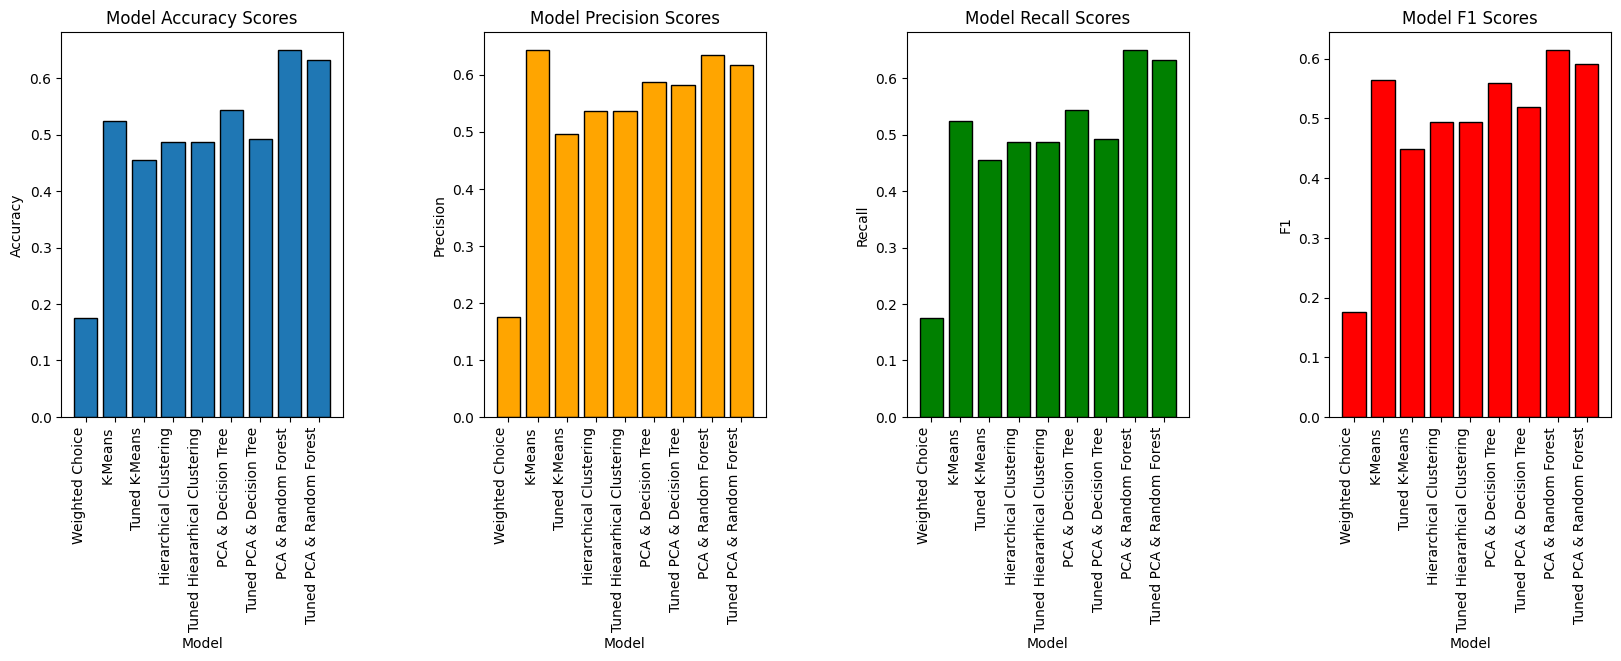

In [173]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
ax[0].bar(model_type, acc, edgecolor = 'black')
ax[0].set_title("Model Accuracy Scores")
ax[0].set_xlabel("Model")
ax[0].set_ylabel("Accuracy")
ax[0].set_xticklabels(model_type, rotation=90, ha='right')

ax[1].bar(model_type, prec, edgecolor = 'black', color = 'orange')
ax[1].set_title("Model Precision Scores")
ax[1].set_xlabel("Model")
ax[1].set_ylabel("Precision")
ax[1].set_xticklabels(model_type, rotation=90, ha='right')

ax[2].bar(model_type, rec, edgecolor = 'black', color = 'green')
ax[2].set_title("Model Recall Scores")
ax[2].set_xlabel("Model")
ax[2].set_ylabel("Recall")
ax[2].set_xticklabels(model_type, rotation=90, ha='right')

ax[3].bar(model_type, f1, edgecolor = 'black', color = 'red')
ax[3].set_title("Model F1 Scores")
ax[3].set_xlabel("Model")
ax[3].set_ylabel("F1")
ax[3].set_xticklabels(model_type, rotation=90, ha='right')

plt.subplots_adjust(wspace=0.5) 
plt.show()

The bar plots above make a few insights easier to see. Firstly, all models exceeded the weighted random choice by a factor of 2.5-3x, which demonstrates that every model was able to perform some "learning" and glean useful information from the feature set. Secondly, among all compared models, the un-tuned versions that used the default sklearn parameters all performed better than their "tuned" counterparts. Secondly, among the unsupervised clustering models that were compared, the K-Means model with fewer iterations completed was the one that most correctly clustered the data. 

Now, to analyze some of these insights. 

##### Tuning was no help
As previously stated, every "tuned" model was worse than the "baseline" model that used sklearn's default. There are a couple of reasons that come to mind for this. In the case of the difference between both versions of K-Means, where the version with fewer iterations was better than the one with more iterations and time to converge, this was likely an inconsistency. K-Means is guaranteed to converge with enough time, so the version with less iterations appearing to perform better is likely the result of good placement of the initial centroids and early stopping preventing the clusters from moving further. As stated previously, hierarchical learning is more consistent because it is deterministic, while K-Means is not - speculatively, additional tests with a low iteration K-Means model would have more varied (and likely worse) performance. 

There are a couple of factors that could be preventing the tuned supervised models from performing better than their un-tuned versions. The first is that only two hyperparameters were modified on the Decision Tree among a number of other hyperparameters to explore. Given time, some combination of additional hyperparameters could perform better. Another contributing factor here is that while the baseline Random Forest had no hyperparameter tweaking, the tuned Random Forest was initialized with the "best" hyperparameters from the tuned Decision Tree. Since the tuned Decision Tree performed worse than the untuned one, using the same hyperparameter settings for the smaller trees of the Random Forest could have caused the "tuned" Random Forest to perform worse as a result. 

Another possible cause of this discrepancy in un-tuned vs tuned performance is that the dataset itself is not large enough. The total dataset only includes 281 samples, which is small compared to established machine learning datasets like MNIST and others. This problem is even more pronounced with the supervised models, which can only train on 225 samples. After PCA, this puts the number of samples almost equal with the number of features. With the seven different classes in use, there is likely not enough data for any model, un-tuned or tuned, to fare much better. 

##### Comparing Clustering Models
Once again, while the K-Means version with fewer iterations appears to be better than hierarchical clustering, it is notable that even after re-running a second hierarchical clustering model during the hyperparameter tuning phase, the accuracy of both models were exactly the same. This is indicative of how the model itself is deterministic and therefore consistent. The accuracy of K-Means is variable depending on the position of the initial centroids and if the model is given adequate time to converge. 

Another point of interest is comparing the unsupervised models used here with the performance listed by the SBCB with the original dataset. While the SBCB got a Hierarchical Clustering accuracy of 0.27 with this dataset, the model trained here was able to reach 0.48. That is the only model that was able to exceed the performance of the SBCB. By contrast, the K-Means model given additional time to converge was also converging to the same value achieved by the SBCB. This is likely additional evidence of what has already been expressed: (1) K-Means always converges given enough time and (2) the K-Means model with fewer iterations here benefitted from better initial centroid placement. 

##### Unsupervised vs Supervised Models
Looking at the visualizations, it is clear that, by most metrics, the supervised models performed better than the unsupervised ones. It's worthwhile to ask whether this comparison is valid given the differences between the models. Firstly, clustering and classification are different tasks. The only reason they can be treated as similar is because of the dataset in use here. Under other conditions, where a dataset had no labels, classification would be entirely impossible and clustering would have no pre-defined goal. In this instance, where the number of distinct classes is known, clustering and classification can be treated the same because, theoretically, the clusters and the classes ought to be the same. Secondly, unsupervised models operate on the entire dataset, with no training and testing split, where supervised models only train and test on subsets of the data. Is it valid to compare their performance given this? To answer this question, I would say that, in almost all cases, models benefit from access to more data. That the supervised models, using a smaller training set, were able to exceed the clustering accuracy of the unsupervised models with all of the data demonstrates the efficacy of supervised models for these sorts of tasks. It also demonstrates the usefulness of Principal Component Analysis, the other unsupervised learning model tested here in this project, because, without it, neither Decision Trees nor a Random Forest would be able to classify such a high-dimensional dataset.  

## Discusion & Conclusion 

In exploring the applications of unsupervised learning to a high-dimensional dataset, all of the models explored demonstrated their usefulness. Since the data is a high-dimensional dataset of 281 samples with 22000+ features, unsupervised models are particularly suited to this scenario. In the absence of supervised models, clustering can be used as a stand-in for multiclass classification because any classes should match different clusters. The benefit of K-Means is the guarantee that it will converge with time, and the benefit of Hierarchical Clustering is that the results will always be consistent. That was demonstrated in this project. Beyond simple clustering algorithms, unsupervised learning can be applied through methods like Principal Component Analysis to preprocess data and reduce dimensionality so that supervised models that suffer with too-high-dimensional data can still be applied to a particular dataset. 

It is disappointing that the performance of the supervised learning models used in this project do not match those of the dataset's host. The performance of their Decision Tree and Random Forest models were beyond what even the "tuned" models used here were capable of. Still, the usefulness of supervised learning models can be seen in how the Decision Tree and Random Forest Classifiers were able to exceed the performance of K-Means and Hiearchical Clustering by nearly every metric. 

There are a few different ways in which this project might be improved:

1) Running additional hyperparameter tuning tests with both Decision Trees and Random Forests. Since only a limited number of hyperparameters were tuned (and tuning negatively impacted the performance of the base model), experimenting with more combinations could be the answer to pushing performance even higher.
2) Researching and compiling multiple similar leukemia datasets into one larger set. While the data contains a large number of features representing individual genes, the total number of samples is still low at 281. With access to additional data, all models involved would likely perform better. Furthermore, supplementing this dataset with others would help to balance the skew seen in the distribution of labels within the dataset at present. 
3) Though the purpose of this project is to explore unsupervised learning, the direction this one took in practice was very similar to supervised learning. An alternative direction to take with it would be to choose unlabeled data where the number of labels is unknown and expore what insights can be extracted from the data with unsupervised models. 

[1] https://scikit-learn.org/stable/modules/model_evaluation.html